In [196]:
import os, operator
import numpy as np
import pandas as pd
pd.options.display.max_columns = 999

import matplotlib.pyplot as plt

from sklearn.linear_model import RidgeCV, LassoCV, LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from scipy.special import inv_boxcox
from scipy.stats import boxcox

import statsmodels.api as sm

import nltk, string, os
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist
from nltk.stem.snowball import SnowballStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
np.random.seed(0)

In [13]:
from Axe_Object import Axe

In [14]:
filenames = [name for name in os.listdir('axe_specs/') if not name.startswith('.')] # Ignores hidden files on mac

In [171]:
axes = []
for filename in filenames:
    try:
        this_axe = Axe(filename)
        if "LOT OF" not in this_axe.title.upper() and this_axe.price > 110 and this_axe.price < 2000:
            if this_axe.string_config and this_axe.string_config < 5:
                continue
            if this_axe.market != 'EBAY-US':
                continue
            if this_axe.year and this_axe.year > 2019:
                continue
            axes.append(this_axe)
    except ValueError:
        pass

In [172]:
len(axes)

12467

In [173]:
prices = pd.Series([axe.price for axe in axes], name = 'prices')

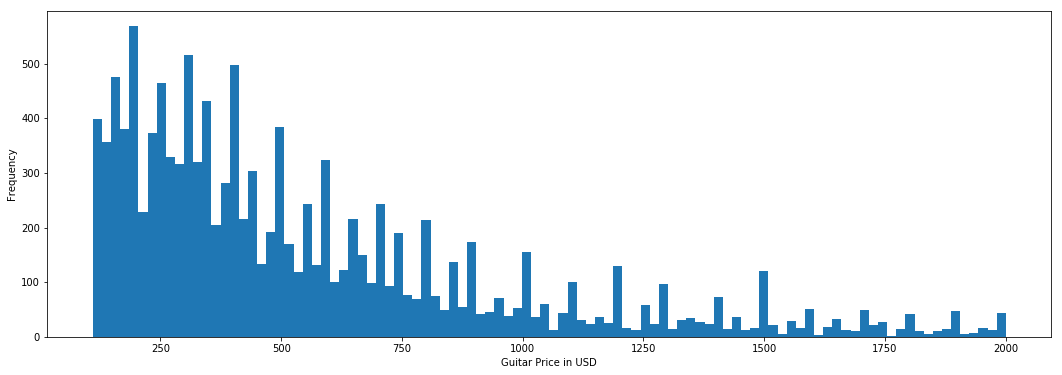

In [174]:
plt.figure(figsize = (18,6))
plt.hist(prices, bins=100)
plt.ylabel('Frequency')
plt.xlabel('Guitar Price in USD')
plt.show()

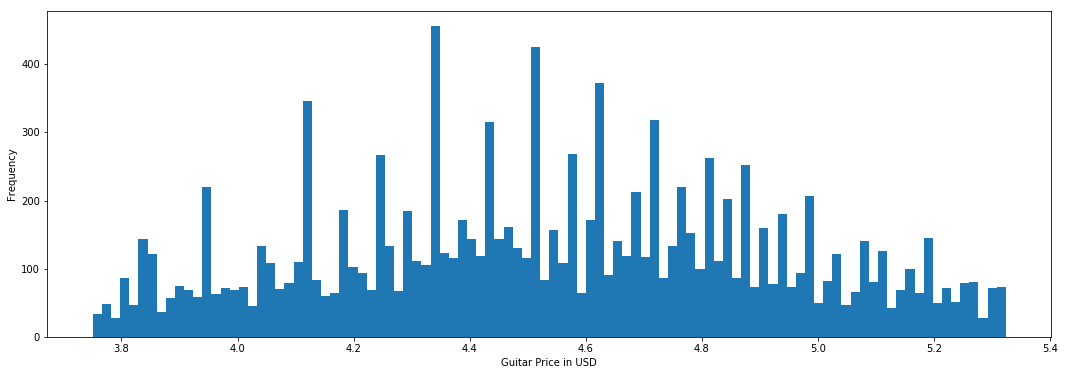

In [181]:
bxcx_lam = -.1
prices = pd.Series(boxcox([axe.price for axe in axes], lmbda=bxcx_lam), name = 'prices')
plt.figure(figsize = (18,6))
plt.hist(prices, bins=100)
plt.ylabel('Frequency')
plt.xlabel('Guitar Price in USD')
plt.show()

In [182]:
auction_duration = pd.Series([axe.duration for axe in axes], name = 'auction_duration')
shipping_charged = pd.Series([axe.price_shipping for axe in axes], name = 'shipping_charged')
seller_country   = pd.Series([axe.country_seller for axe in axes], name = 'seller_country')
autopay          = pd.Series([axe.autopay for axe in axes], name = 'autopay')
returns          = pd.Series([axe.returns for axe in axes], name = 'returns')
listing_type     = pd.Series([axe.listing_type for axe in axes], name = 'listing_type')
ship_type        = pd.Series([axe.ship_type for axe in axes], name = 'ship_type')
ship_expedite    = pd.Series([axe.ship_expedite for axe in axes], name = 'ship_expedite')
start_hour       = pd.cut(pd.Series([axe.start_time.hour for axe in axes], name = 'start_hour'), 6)
end_hour         = pd.cut(pd.Series([axe.end_time.hour for axe in axes], name = 'end_hour'), 6)
start_weekday    = pd.Series([axe.start_weekday for axe in axes], name = 'start_weekday').astype('category')
end_weekday      = pd.Series([axe.end_weekday for axe in axes], name = 'end_weekday').astype('category')
returns_time     = pd.Series([axe.returns_time for axe in axes], name = "returns_time").astype('category')
num_pics         = pd.Series([axe.pic_quantity for axe in axes], name = "num_pics")
brand            = pd.Series([axe.brand for axe in axes], name = "brand")
body_type        = pd.Series([axe.body_type for axe in axes], name = "body_type")
color            = pd.Series([axe.color for axe in axes], name = "color")
right_left_handed = pd.Series([axe.right_left_handed for axe in axes], name = "right_left_handed")
best_offer_enabled = pd.Series([axe.best_offer_enabled for axe in axes], name = "best_offer_enabled")
country_manufacture = pd.Series([axe.country_manufacture for axe in axes], name = "country_manufacture")

ship_handling_time = pd.Series([axe.ship_handling_time for axe in axes], name = 'ship_handling_time').astype('category')

string_config = pd.cut(pd.Series([axe.string_config for axe in axes], name = "string_config"),
                       [0,5,6,11,20])

seller_feedback_score = pd.cut(pd.Series([axe.seller_feedback_score for axe in axes], name = "seller_feedback_score"), [-411,0,50,100,200,500,750,1250,2500,10000,100000,400000])

seller_positive_percent = pd.cut(pd.Series([axe.seller_positive_percent for axe in axes], name = "seller_positive_percent"), [-10000,99.5,111])

model_year = pd.cut(pd.Series([axe.year for axe in axes], name = "model_year"), [1700,1975,1990,1995,2000,2005,2007,2010,2011,2012,2013,2015])

# model = pd.Series([axe.model for axe in axes], name = "model")

# has_subtitle = []
# for axe in axes:
#     if axe.subtitle != None:
#         has_subtitle.append(True)
#     else: has_subtitle.append(False)
# has_subtitle = pd.Series(has_subtitle, name="has_subtitle")

# has_condition = []
# for axe in axes:
#     if axe.subtitle != None:
#         has_condition.append(True)
#     else: has_condition.append(False)
# has_condition = pd.Series(has_condition, name="has_condition")

In [183]:
# LDA_topic_weights = pd.read_csv('topic_weights.csv', index_col=0)
# LDA_topic_weights = LDA_topic_weights > 0 # Binarizing LDA topics

In [184]:
def assemble_guitar_document(axe):
    document = axe.title + ' '
    if axe.year != None:
        document += (str(axe.year) + ' ')
    if axe.material != None:
        document += axe.material + ' '
    if axe.model != None:
        document += axe.model + ' ' 
    if axe.brand != None:
        document += axe.brand + ' '
    if axe.subtitle != None:
        document += axe.subtitle + ' '
    if axe.condition_description != None:
        document += axe.condition_description + ' '
    if axe.description != None:
        document += axe.description
    return document

In [185]:
raw_corpus = [assemble_guitar_document(axe).lower() for axe in axes]

In [186]:
stemmer = SnowballStemmer("english")

In [187]:
stopwords_list = stopwords.words('english') + list(string.punctuation)
stopwords_list += ["''", '""', '...', '``', ",", ".", ":", "'s", "--","’"]

In [188]:
def process_doc(doc):
    stopwords_removed = ''
    tokens = nltk.word_tokenize(doc)
    for i in range(len(tokens)):
        if tokens[i].lower() not in stopwords_list and tokens[i] not in string.punctuation:
            stopwords_removed += stemmer.stem(tokens[i]) + ' '
    return stopwords_removed

In [189]:
processed_data = list(map(process_doc, raw_corpus))

In [190]:
vectorizer = TfidfVectorizer(norm=None, ngram_range=(2,2), strip_accents='ascii',
#                             max_df=0.8, min_df=2,
                             max_features=300)
tfidf = vectorizer.fit_transform(processed_data)
tfidf_array = tfidf.toarray()

In [191]:
tfidf_df = pd.DataFrame(tfidf_array, columns=vectorizer.get_feature_names())

In [192]:
tfidf_df.head()

,14 day,22 fret,24 hour,30 day,48 state,accept paypal,actual item,ad follow,addit cost,addit ship,alder bodi,american standard,amp amp,amp gt,amp lt,ask question,auction end,back neck,bid confid,bidding buy,bodi electr,bodi finish,bodi mapl,bodi materi,bodi neck,bodi shape,bolt on,brand new,bridg pickup,busi day,buyer pay,buyer pleas,buyer respons,case includ,charg buyer,charg charg,charg includ,check countri,coil pickup,coil split,coil tap,combin ship,come origin,condit guitar,condit use,contact us,cost prior,cost ship,countri custom,custom offic,custom shop,day auction,day payment,day receipt,day return,describ item,determin addit,duti tax,ebay ship,ebay store,electr guitar,electron work,end auction,epiphon les,esp ltd,estim ship,excel condit,feel free,fender american,fender fender,fender squier,fender stratocast,fender telecast,finish gloss,flame mapl,floyd rose,follow inform,free ask,free contact,free ship,fret 22,fret wear,full refund,gibson les,gibson sg,gibson usa,gig bag,good condit,good luck,good shape,good work,great condit,great guitar,great shape,great sound,gt amp,guitar black,guitar case,guitar come,guitar excel,guitar good,guitar great,guitar guitar,guitar hard,guitar look,guitar made,guitar play,guitar ship,guitar use,happi bid,hard case,hard shell,hardshel case,hollow bodi,humbuck pickup,import duti,includ item,includ ship,intern buyer,intern ship,item descript,item list,item must,item pleas,item price,item receiv,item return,item sale,item ship,item sold,jumbo fret,label cost,leav feedback,left hand,length 25,les paul,light scratch,like new,limit edit,local pickup,lock tuner,look like,look pictur,low action,lower 48,made japan,made mexico,made usa,mahogani bodi,mahogani neck,make payment,make sure,mapl neck,mapl top,master volum,mat bridg,medium jumbo,middl pickup,mint condit,money back,music instrument,near mint,neck pickup,neck profil,neck rosewood,neck shape,neck straight,new condit,new string,non pay,number fret,nut width,offic determin,origin case,origin hard,packag label,packag ship,paul custom,paul gibson,paul reed,paul standard,paul studio,pay ship,payment accept,payment must,payment receiv,pick guard,pick up,pickup posit,pickup selector,pickup switch,play great,play guitar,play sound,play wear,play well,pleas ask,pleas check,pleas contact,pleas feel,pleas make,pleas note,pleas read,pleas see,posit bridg,posit feedback,pre own,present print,price ship,print packag,prior bid,prior bidding,prioriti mail,pst seller,puerto rico,purchas item,push pul,question bid,question may,question pleas,receiv item,receiv within,reed smith,reserv right,respons pleas,restock fee,return item,return polici,return ship,right hand,rosewood fingerboard,rosewood fretboard,sale final,sale tax,scale length,see photo,see pic,see pictur,seller ad,semi hollow,send us,serial number,set neck,seymour duncan,shell case,ship address,ship calcul,ship charg,ship compani,ship confirm,ship cost,ship fee,ship insur,ship intern,ship item,ship lower,ship pleas,ship quot,ship ship,ship within,sign wear,singl coil,single coil,small ding,soft case,solid bodi,solid wood,solidbodi electr,sound great,standard stratocast,state ship,stratocast electr,stratocast fender,string electr,tax charg,telecast fender,thank look,tone control,track number,truss rod,tune machin,tune mat,unit state,up ground,us question,use condit,use guitar,usp prioriti,vintage styl,volum tone,way pickup,way switch,whammi bar,within 30,within busi,within day,work condit,would like,year old,zip code
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.720494,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,3.664729,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.03733,3.096591,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.408169,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.113726,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,2.987257,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [193]:
tfidf_df.shape

(12467, 300)

***

In [194]:
X_no_dummies = pd.concat([prices, tfidf_df, brand, color, country_manufacture, right_left_handed, best_offer_enabled, shipping_charged, 
               returns, returns_time, autopay,seller_country, ship_handling_time, listing_type, ship_expedite,
               ship_type, num_pics, auction_duration, start_hour, end_hour, start_weekday, end_weekday, 
               seller_feedback_score, seller_positive_percent, model_year, body_type, string_config],
#              LDA_topic_weights],
              axis = 1)

X = pd.get_dummies(X_no_dummies, drop_first=True)

In [195]:
len(X.columns)

434

### Lasso Regression

In [140]:
X_train, X_test, y_train, y_test = train_test_split(X.iloc[:,1:], X.iloc[:,0])

In [148]:
# alphas = np.logspace(-4, -0.5, 30)
lin_reg = RidgeCV().fit(X_train, y_train)

In [149]:
y_train_preds = lin_reg.predict(X_train)
y_test_preds = lin_reg.predict(X_test)

In [150]:
price_mean = np.mean([axe.price for axe in axes])
price_mean_vector = [price_mean for i in range(len(y_test))]
baseline_error = np.sqrt(mean_squared_error(y_test, price_mean_vector))
baseline_error

379.8218637477378

In [151]:
y_train_inv = inv_boxcox(y_train, bxcx_lam)
y_test_inv = inv_boxcox(y_test, bxcx_lam)
y_train_preds_inv = inv_boxcox(y_train_preds, bxcx_lam)
y_test_preds_inv = inv_boxcox(y_test_preds, bxcx_lam)

In [152]:
train_error = np.sqrt(mean_squared_error(y_train_inv, y_train_preds_inv))
test_error = np.sqrt(mean_squared_error(y_test_inv, y_test_preds_inv))
(train_error, test_error)

(154.63596424290458, 163.65436360282274)

In [153]:
print(f'Train error is a {round((((baseline_error - train_error) / baseline_error) * 100),2)}% improvement over guessing the mean. \n')

print(f'Test error is a {round((((baseline_error - test_error) / baseline_error) * 100),2)}% improvement over guessing the mean.')

Train error is a 59.29% improvement over guessing the mean. 

Test error is a 56.91% improvement over guessing the mean.


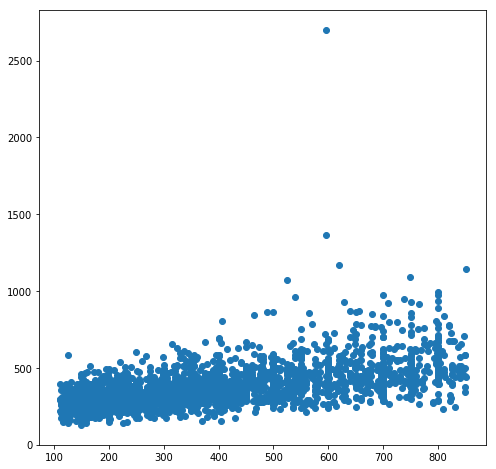

In [170]:
plt.figure(figsize=(8,8))
plt.scatter(y_test_inv, y_test_preds_inv)
plt.show()

In [155]:
sorted(dict(zip(X.columns, lin_reg.coef_)).items(), key=operator.itemgetter(1), reverse=True)

[('brand_PEAVEY', 0.7459966867204885),
 ('country_manufacture_UNKNOWN', 0.6873468141292891),
 ('brand_G&L', 0.6746579373014927),
 ('ship_type_FlatDomesticCalculatedInternational', 0.5634238947451364),
 ('model_year_(2010, 2011]', 0.5170427334719123),
 ('model_year_(2005, 2007]', 0.5162337562616461),
 ('model_year_(2013, 2015]', 0.512470593205849),
 ('model_year_(2012, 2013]', 0.4643174125222278),
 ('model_year_(2011, 2012]', 0.45632199231863635),
 ('string_config_(6, 11]', 0.4372112089912882),
 ('brand_ESP', 0.41863524248980066),
 ('brand_PRS', 0.4133805822792068),
 ('describ item', 0.4055153832943539),
 ('ship_handling_time_15', 0.3991462222657369),
 ('model_year_(2007, 2010]', 0.39684262416315574),
 ('listing_type_FixedPrice', 0.3790411667208038),
 ('brand_FENDER', 0.3727298161091419),
 ('brand_GIBSON', 0.3679869574344456),
 ('color_BLUE', 0.3497041633575433),
 ('model_year_(2000, 2005]', 0.3381480838844989),
 ('reserv right', 0.3196639238996406),
 ('seller_positive_percent_(99.5, 11

In [202]:
X_sm = sm.add_constant(X_train)

model = sm.OLS(y_train,X_sm.astype(float)).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 prices   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.371
Method:                 Least Squares   F-statistic:                     11.56
Date:                Fri, 01 Feb 2019   Prob (F-statistic):               0.00
Time:                        18:54:04   Log-Likelihood:                -12788.
No. Observations:                7573   AIC:                         2.642e+04
Df Residuals:                    7149   BIC:                         2.936e+04
Df Model:                         423                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                             9.9511      0.354     28.119      0.000       9.257      10.645
14 day                                            0.0327      0.027      1.206      0.228      -0.020       0.086
22 fret                                          -0.0273      0.022     -1.269      0.204      -0.069       0.015
30 day                                            0.0522      0.034      1.529      0.126      -0.015       0.119
48 state                                         -0.0060      0.024     -0.246      0.805      -0.054       0.042
accept paypal                                    -0.0501      0.031     -1.601      0.110      -0.111       0.011
actual item                                       0.0047      0.030      0.160      0.873      -0.053       0.063
ad follow                                        -0.6123      0.322     -1.901      0.057      -1.244       0.019
addit cost                                       -0.1404      0.078     -1.807      0.071      -0.293       0.012
addit ship                                       -0.0167      0.045     -0.370      0.712      -0.105       0.072
alder bodi                                        0.0199      0.019      1.030      0.303      -0.018       0.058
american standard                                 0.0478      0.017      2.887      0.004       0.015       0.080
amp amp                                        2.687e-05   6.93e-05      0.388      0.698      -0.000       0.000
amp gt                                           -0.0359      0.210     -0.171      0.864      -0.448       0.376
amp lt                                           -0.0359      0.210     -0.171      0.864      -0.448       0.376
ask question                                      0.0136      0.023      0.582      0.561      -0.032       0.059
auction end                                      -0.0225      0.027     -0.842      0.400      -0.075       0.030
back neck                                        -0.0055      0.019     -0.292      0.770      -0.043       0.032
bid confid                                        0.0132      0.024      0.559      0.576      -0.033       0.059
bidding buy                                      -0.1650      0.077     -2.136      0.033      -0.316      -0.014
bodi electr                                       0.0155      0.019      0.803      0.422      -0.022       0.053
bodi neck                                        -0.0076      0.018     -0.430      0.667      -0.042       0.027
bodi shape                                        0.0537      0.032      1.665      0.096      -0.010       0.117
bolt on                                          -0.0508      0.019     -2.694      0.007      -0.088      -0.014
brand

In [ ]:
# Cheap image analysis - white balance?
# Transfer learning on quality of image
# Present Insights about time of day / day of week